<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

Author: [Alexey Natekin](https://www.linkedin.com/in/natekin/), OpenDataScience founder, Machine Learning Evangelist. Translated and edited by [Olga Daykhovskaya](https://www.linkedin.com/in/odaykhovskaya/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

<h1 align="center"> Topic 10. Gradient Boosting and CatBoost</h1> 

<img src='https://habrastorage.org/web/4a9/edb/082/4a9edb082408442ea47a12b75f19d122.jpg' align='center' width=50%>
 


## Lecture Outline
We recommend going over this material in the order described below, but feel free to jump around between sections.  

* 2 [Gradient boosting: overview](#Gradient-boosting:-overview)
* 3 [Introduction and history of boosting](#Introduction-and-history-of-boosting)        
     * 3.1 [History of Gradient Boosting Machine](#History-of-GBM)
     * 3.2 [GBM algorithm](#GBM-algorithm)
       * 3.2.1 [ML Problem statement](#ML-problem-statement)
       * 3.2.2 [Functional gradient descent](#Functional-gradient-descent)
       * 3.2.3[Friedman's classic GBM algorithm](#Friedman's-classic-GBM-algorithm)
       * 3.2.4 [Step-by-step example of the GBM algorithm](#Step-By-Step-example:-How-GBM-Works)
     * 3.3 [Loss functions](#Loss-functions)
       * 3.3.1 [Regression loss functions](#Regression-loss-functions)
       * 3.3.2 [Classification loss functions](#Classification-loss-functions)
       * 3.3.3 [Weights](#Weights)
    * 3.4 [Conclusion](#Conclusion)
* 4 [CatBoost](#CatBoost)
    * 4.1 [Overview](#Overview)
    * 4.2 [Benchmarks](#Benchmarks)
    * 4.3 [Core Improvements](#Core-Improvements)
        * 4.3.1 [Categorical features](#Categorical-features)
            * 4.3.1.1 [Encoding](#Encoding)
            * 4.3.1.1 [Feature Combinations](#Feature-Combinations)
        * 4.3.2 [Fighting gradient biases](#Fighting-gradient-biases)
            * 4.3.2.1 [Ordered boosting](#Ordered-boosting)
            * 4.3.2.2 [Symmetric/Oblivious trees](#Symmetric/Oblivious-trees)
        * 4.3.3 [Tuning Parameters](#Tuning-Parameters)
     * 4.4 [Tutorial](#Tutorial)
         * 4.4.1 [Performance and speed test](#Performance-and-speed-test)
         * 4.4.2 [Using baseline](#Using-baseline)
         * 4.4.3 [Pool object](#Pool-object)
         * 4.4.4 [Custom loss functions](#Custom-loss-functions) 
         * 4.4.5 [Model comparison](#Model-comparison) 
         * 4.4.6 [Cross-validation](#Cross-validation) 
         * 4.4.7 [Grid search](#Grid-search)          
         * 4.4.8 [Overfitting detector](#Overfitting-detector)         
         * 4.4.9 [Model predictions](#Model-predictions)          
         * 4.4.10 [Feature statistics](#Feature-statistics)             
* 5 [XGBoost vs LightGBM vs CatBoost](#XGBoost-vs-LightGBM-vs-CatBoost)
* 6 [Demo assignment](#Demo-assignment)
* 7 [Useful resources](#Useful-resources)

# Gradient boosting: overview

* **Bagging** is a simple ensembling technique in which we build many independent predictors/models/learners and combine them using some model averaging techniques. (e.g. weighted average, majority vote or normal average)

* **Boosting** is an ensemble technique in which the predictors are not made independently, but sequentially

<img src= '../../img/gbm_1.png'  align='center' />

<img src= '../../img/gbm_2.png'  align='center' />

# Introduction and history of boosting

Almost everyone in machine learning has heard about gradient boosting. Many data scientists include this algorithm in their data scientist's toolbox because of the good results it yields on any given (unknown) problem. 

Furthermore, XGBoost is often the standard recipe for [winning](https://github.com/dmlc/xgboost/blob/master/demo/README.md#usecases) [ML competitions](http://blog.kaggle.com/tag/xgboost/). It is so popular that the idea of stacking XGBoosts has become a meme. Moreover, boosting is an important component in [many recommender systems](https://en.wikipedia.org/wiki/Learning_to_rank#Practical_usage_by_search_engines); sometimes, it is even considered a [brand](https://yandex.com/company/technologies/matrixnet/).

Let's look at the history and development of boosting.
Boosting was born out of [the question:](http://www.cis.upenn.edu/~mkearns/papers/boostnote.pdf) is it possible to get one strong model from a large amount of relatively weak and simple models? By saying "weak models", we do not mean simple basic models like decision trees but models with poor accuracy performance, where poor is a little bit better than random.

[A positive mathematical answer](http://www.cs.princeton.edu/~schapire/papers/strengthofweak.pdf) to this question was identified, but it took a few years to develop fully functioning algorithms based on this solution e.g. AdaBoost. These algoritms take a greedy approach: first, they build a linear combination of simple models (basic algorithms) by re-weighing the input data. Then, the model (usually a decision tree) is built on earlier incorrectly predicted objects, which are now given larger weights.  

<spoiler title="More about AdaBoost">
Many machine learning courses study AdaBoost - the ancestor of GBM (Gradient Boosting Machine). However, since AdaBoost merged with GBM, it has become apparent that AdaBoost is just a particular variation of GBM.  

The algorithm itself has a very clear visual interpretation and intuition for defining weights. Let's have a look at the following toy classification problem where we are going to split the data between the trees of depth 1 (also known as 'stumps') on each iteration of AdaBoost. For the first 3 iterations, we have the following picture:

<img src='https://habrastorage.org/web/d28/78f/7ba/d2878f7bad0340fc8002e5ba6d0879a5.jpg' width=70%>

The size of point corresponds to its weight, which was assigned for an incorrect prediction.  On each iteration, we can see that these weights are growing -- the stumps cannot cope with this problem. Although, if we take a weighted vote for the stumps, we will get the correct classifications:

<img src='https://habrastorage.org/web/b2b/029/d89/b2b029d898f64bbbb158e15d29595969.png' width=70%>

Pseudocode:
- Initialize sample weights $\Large w_i^{(0)} = \frac{1}{l}, i = 1, \dots, l$.
- For all $t = 1, \dots, T$
    * Train base algo $\Large b_t$, let $\epsilon_t$ be it's training error.
    * $\Large \alpha_t = \frac{1}{2}ln\frac{1 - \epsilon_t}{\epsilon_t}$.
    * Update sample weights: $\Large w_i^{(t)} = w_i^{(t-1)} e^{-\alpha_t y_i b_t(x_i)}, i = 1, \dots, l$.
    * Normalize sample weights: $\Large w_0^{(t)} = \sum_{j = 1}^k w_j^{(t)}, w_i^{(t)} = \frac{w_i^{(t)}}{w_0^{(t)}}, i = 1, \dots, l$.
- Return $\sum_t^{T}\alpha_tb_t$


[Here](https://www.youtube.com/watch?v=k4G2VCuOMMg) is more detailed example of AdaBoost where, as we iterate, we can see the weights increase, especially on the border between classes.

AdaBoost works well, but [the lack](https://www.cs.princeton.edu/courses/archive/spring07/cos424/papers/boosting-survey.pdf) of explanation for why the algorithm is successful sewed the seeds of doubt. Some considered it a super-algorithm, a silver bullet, but others were skeptical and believed AdaBoost was just overfitting. 

The overfitting problem did indeed exist, especially when data had strong outliers. Therefore, in those types of problems, AdaBoost was unstable. Fortunately, a few professors in the statistics department at Stanford, who had created Lasso, Elastic Net, and Random Forest, started researching the algorithm. In 1999, Jerome Friedman came up with the generalization of boosting algorithms development - Gradient Boosting (Machine), also known as GBM. With this work, Friedman set up the statistical foundation for many algorithms providing the general approach of boosting for optimization in the functional space.

CART, bootstrap, and many other algorithms have originated from Stanford's statistics department. In doing so, the department has solidified their names in future textbooks. These algorithms are very practical, and some recent works have yet to be widely adopted. For example, check out [glinternet](https://arxiv.org/abs/1308.2719).  

Not many video recordings of Friedman are available. Although, there is a very interesting [interview](https://www.youtube.com/watch?v=8hupHmBVvb0) with him about the creation of CART and how they solved statistics problems (which is similar to data analysis and data science today) more than 40 years ago.

There is also a great [lecture](https://www.youtube.com/watch?v=zBk3PK3g-Fc) from Hastie, a retrospective on data analysis from one of the creators of methods that we use everyday.

In general, there has been a transition from engineering and algorithmic research to a full-fledged approach to building and studying algorithms. From a mathematical perspective, this is not a big change - we are still adding (or boosting) weak algorithms and enlarging our ensemble with gradual improvements for parts of the data where the model was inaccurate. But, this time, the next simple model is not just built on re-weighted objects but improves its approximation of the gradient of overall objective function. This concept greatly opens up our algorithms for imagination and extensions.

<img src="https://habrastorage.org/webt/h2/v4/k9/h2v4k9r-4yn4jwvwz99fbss4ghi.png" />

## History of GBM

It took more than 10 years after the introduction of GBM for it to become an essential part of the data science toolbox.   
GBM was extended to apply to different statistics problems: GLMboost and GAMboost for strengthening already existing GAM models, CoxBoost for survival curves, and RankBoost and LambdaMART for ranking.   
Many realizations of GBM also appeared under different names and on different platforms: Stochastic GBM, GBDT (Gradient Boosted Decision Trees), GBRT (Gradient Boosted Regression Trees), MART (Multiple Additive Regression Trees), and more. In addition, the ML community was very segmented and dissociated, which made it hard to track just how widespread boosting had become.  

At the same time, boosting had been actively used in search ranking. This problem was rewritten in terms of a loss function that penalizes errors in the output order, so it became convenient to simply insert it into GBM. AltaVista was one of the first companies who introduced boosting to ranking. Soon, the ideas spread to Yahoo, Yandex, Bing, etc. Once this happened, boosting became one of the main algorithms that was used not only in research but also in core technologies in industry.

<img src='https://habrastorage.org/web/48a/ea4/fff/48aea4fffdbe4e5f9205ba81110e6061.jpg' align='right' width=30%> ML competitions, especially Kaggle, played a major role in boosting's popularization. Now, researchers had a common platform where they could compete in different data science problems with large number of participants from around the world. With Kaggle, one could test new algorithms on the real data, giving algoritms oppurtunity to "shine", and provide full information in sharing model performance results across competition data sets. This is exactly what happened to boosting when it was used at [Kaggle](http://blog.kaggle.com/2011/12/21/score-xavier-conort-on-coming-second-in-give-me-some-credit/) (check interviews with Kaggle winners starting from 2011 who mostly used boosting). The [XGBoost](https://github.com/dmlc/xgboost) library quickly gained popularity after its appearance. XGBoost is not a new, unique algorithm; it is just an extremely effective realization of classic GBM with additional heuristics.

This algorithm has gone through very typical path for ML algorithms today: mathematical problem and algorithmic crafts to successful practical applications and mass adoption years after its first appearance.

## GBM algorithm
### ML problem statement

We are going to solve the problem of function approximation in a general supervised learning setting. We have a set of features $ \large x $ and target variables $\large y, \large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$ which we use to restore the dependence $\large y = f(x) $. We restore the dependence by approximating $ \large \hat{f}(x) $ and by understanding which approximation is better when we use the loss function $ \large L(y,f) $, which we want to minimize: $ \large y \approx \hat{f}(x), \large \hat{f}(x) = \underset{f(x)}{\arg\min} \ L(y,f(x)) $.  

<img src='../../img/topic10_help_with_func.png'  align='center'>

At this moment, we do not make any assumptions regarding the type of dependence $ \large f(x) $, the model of our approximation $ \large \hat{f}(x) $, or the distribution of the target variable $ \large y $. We only expect the function $ \large L(y,f) $ to be differentiable. Our approach is very general: we define $ \large \hat {f}(x) $ by minimizing the loss:  
$$ \large  \hat{f}(x) = \underset{f(x)}{\arg\min} \ \mathbb {E} _{x,y}[L(y,f(x))]  $$

Unfortunately, the number of functions $ \large f(x) $ is not just large, but its functional space is infinite-dimensional. That is why it is acceptable for us to limit the search space by some family of functions $ \large f(x, \theta), \theta \in \mathbb{R}^d $. This simplifies the objective a lot because now we have a solvable optimization of parameter values:
$ \large \hat{f}(x) = f(x, \hat{\theta}),$
$$\large \hat{\theta} = \underset{\theta}{\arg\min} \ \mathbb {E} _{x,y}[L(y,f(x,\theta))] $$

Simple analytical solutions for finding the optimal parameters $ \large \hat{\theta} $ often do not exist, so the parameters are usually approximated iteratively. To start, we write down the empirical loss function $ \large L_{\theta}(\hat{\theta}) $ that will allow us to evaluate our parameters using our data. Additionally, let's write out our approximation $ \large \hat{\theta} $ for a number of $ \large M $ iterations as a sum:  
$ \large \hat{\theta} = \sum_{i = 1}^M \hat{\theta_i}, \\
\large L_{\theta}(\hat{\theta}) =  \sum_{i = 1}^N L(y_i,f(x_i, \hat{\theta}))$  

Then, the only thing left is to find a suitable, iterative algorithm to minimize $\large L_{\theta}(\hat{\theta})$. Gradient descent is the simplest and most frequently used option. We define the gradient as $\large \nabla L_{\theta}(\hat{\theta})$ and add our iterative evaluations $\large \hat{\theta_i}$ to it (since we are minimizing the loss, we add the minus sign). Our last step is to initialize our first approximation $\large \hat{\theta_0}$ and choose the number of iterations $\large M$. Let's review the steps for this inefficient and naive algorithm for approximating $\large \hat{\theta}$:

1. Define the initial approximation of the parameters $\large \hat{\theta} = \hat{\theta_0}$
2. For every iteration $\large t = 1, \dots, M$ repeat steps 3-7:
1. Calculate the gradient of the loss function $\large \nabla L_{\theta}(\hat{\theta})$ for the current approximation $\large \hat{\theta}$
$\large \nabla L_{\theta}(\hat{\theta}) = \left[\frac{\partial L(y, f(x, \theta))}{\partial \theta}\right]_{\theta = \hat{\theta}}$
2. Set the current iterative approximation $\large \hat{\theta_t}$ based on the calculated gradient
$\large \hat{\theta_t} \leftarrow −\nabla L_{\theta}(\hat{\theta})$
3. Update the approximation of the parameters $\large \hat{\theta}$:
$\large \hat{\theta} \leftarrow \hat{\theta} + \hat{\theta_t} = \sum_{i = 0}^t \hat{\theta_i} $
3. Save the result of approximation $\large \hat{\theta}$:
$\large \hat{\theta} = \sum_{i = 0}^M \hat{\theta_i} $
4. Use the function that was found $\large \hat{f}(x) = f(x, \hat{\theta})$

<img src='https://habrastorage.org/web/2b5/5d6/90d/2b55d690d99e4ec0976b360aae6ce4df.jpg'   align='center'>

### Functional gradient descent

Let's imagine for a second that we can perform optimization in the function space and iteratively search for the approximations $\large \hat{f}(x)$ as functions themselves. We will express our approximation as a sum of incremental improvements, each being a function. For convenience, we will immediately start with the sum from the initial approximation $\large \hat{f_0}(x)$:
$$\large \hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x)$$

Nothing has happened yet; we have only decided that we will search for our approximation $\large \hat{f}(x)$ not as a big model with plenty of parameters (as an example, neural network), but as a sum of functions, pretending we move in functional space.

In order to accomplish this task, we need to limit our search by some function family $\large \hat{f}(x) = h(x, \theta)$. There are a few issues here -- first of all, the sum of models can be more complicated than any model from this family; secondly, the general objective is still in functional space. Let's note that, on every step, we will need to select an optimal coefficient $\large \rho \in \mathbb{R}$. For step $\large t$, the problem is the following:
$$\large \hat{f}(x) = \sum_{i = 0}^{t-1} \hat{f_i}(x), \\
\large (\rho_t,\theta_t) = \underset{\rho,\theta}{\arg\min} \ \mathbb {E} _{x,y}[L(y,\hat{f}(x) +  \rho \cdot h(x, \theta))], \\
\large \hat{f_t}(x) = \rho_t \cdot h(x, \theta_t)$$

Here is where the magic happens. We have defined all of our objectives in general terms, as if we could have trained any kind of model $\large h(x, \theta)$ for any type of loss functions $\large L(y, f(x, \theta))$. In practice, this is extremely difficult, but, fortunately, there is a simple way to solve this task.

Knowing the expression of loss function's gradient, we can calculate its value on our data. So, let's train the models such that our predictions will be more correlated with this gradient (with a minus sign). In other words, we will use least squares to correct the predictions with these residuals. For classification, regression, and ranking tasks, we will minimize the squared difference between pseudo-residuals $\large r$ and our predictions. For step $\large t$, the final problem looks like the following:
$$ \large \hat{f}(x) = \sum_{i = 0}^{t-1} \hat{f_i}(x), \\
\large r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad \mbox{for } i=1,\ldots,n ,\\
\large \theta_t = \underset{\theta}{\arg\min} \ \sum_{i = 1}^{n} (r_{it} - h(x_i, \theta))^2, \\
\large \rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) + \rho \cdot h(x_i, \theta_t))$$

<img src='../../img/topic10_regression_for_everybody.jpg'   align='center' width=60%>

### Friedman's classic GBM algorithm

We can now define the classic GBM algorithm suggested by Jerome Friedman in 1999. It is a supervised algorithm that has the following components:

- dataset $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,n}$;
- number of iterations $\large M$;
- choice of loss function $\large L(y, f)$ with a defined gradient;
- choice of function family of base algorithms $\large h(x, \theta)$ with the training procedure;
- additional hyperparameters $\large h(x, \theta)$ (for example, in decision trees, the tree depth);

The only thing left is the initial approximation $\large f_0(x)$. For simplicity, for an initial approximation, a constant value $\large \gamma$ is used. The constant value, as well as the optimal coefficient $\large \rho $, are identified via binary search or another line search algorithm over the initial loss function (not a gradient). So, we have our GBM algorithm described as follows:

1. Initialize GBM with constant value $\large \hat{f}(x) = \hat{f}_0, \hat{f}_0 = \gamma,  \gamma \in \mathbb{R}$
$\large \hat{f}_0 = \underset{\gamma}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \gamma)$
2. For each iteration $\large t = 1, \dots, M$, repeat:
1. Calculate pseudo-residuals $\large r_t$ 
$\large r_{it} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad \mbox{for } i=1,\ldots,n$
2. Build new base algorithm $\large h_t(x)$ as regression on pseudo-residuals $\large \left\{ (x_i, r_{it}) \right\}_{i=1, \ldots,n}$
3. Find optimal coefficient $\large \rho_t $ at $\large h_t(x)$ regarding initial loss function
$\large \rho_t = \underset{\rho}{\arg\min} \ \sum_{i = 1}^{n} L(y_i, \hat{f}(x_i) +  \rho \cdot h(x_i, \theta))$
4. Save $\large \hat{f_t}(x) = \rho_t \cdot h_t(x)$
5. Update current approximation
$\large \hat{f}(x) \leftarrow \hat{f}(x) + \hat{f_t}(x) = \sum_{i = 0}^{t} \hat{f_i}(x)$
3. Compose final GBM model
$\large \hat{f}(x) = \sum_{i = 0}^M \hat{f_i}(x) $
4. Conquer Kaggle and the rest of the world

### Step-By-Step example: How GBM Works

Let's see an example of how GBM works. In this toy example, we will restore a noisy function $\large y = cos(x) + \epsilon, \epsilon \sim \mathcal{N}(0, \frac{1}{5}), x \in [-5,5]$.

<img src='https://habrastorage.org/web/9fe/04d/7ba/9fe04d7ba5a645d49fc6aa3e875c8c41.jpg'   align='center'>

This is a regression problem with a real-valued target, so we will choose to use the mean squared error loss function. We will generate 300 pairs of observations and approximate them with decision trees of depth 2. Let's put together everything we need to use GBM:
- Toy data $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}$ ✓
- Number of iterations $\large M = 3$ ✓;
- The squared error loss function $\large L(y, f) = \sum_{i = 1}^n (y-f)^2$ ✓
- Gradient of $\large L(y, f) = L_2$ loss is just residuals $\large r = (y - f)$ ✓;
- Decision trees as base algorithms $\large h(x)$ ✓;
- Hyperparameters of the decision trees: trees depth is equal to 2 ✓;

For the squared error, both initialization $\large \gamma$ and coefficients $\large \rho_t$ are simple. We will initialize GBM with the average value $\large \gamma = \frac{1}{n} \cdot \sum_{i = 1}^n y_i$, and set all coefficients $\large \rho_t$ to 1.

We will run GBM and draw two types of graphs: the current approximation $\large \hat{f}(x)$ (blue graph) and every tree $\large \hat{f_t}(x)$ built on its pseudo-residuals (green graph). The graph's number corresponds to the iteration number:

<img src='https://habrastorage.org/web/edb/328/98a/edb32898ad014d8d95782759d11f63fb.png'   align='center'>

By the second iteration, our trees have recovered the basic form of the function. However, at the first iteration, we see that the algorithm has built only the "left branch" of the function ($\large x \in [-5, -4]$). This was due to the fact that our trees simply did not have enough depth to build a symmetrical branch at once, and it focused on the left branch with the larger error. Therefore, the right branch appeared only after the second iteration.

The rest of the process goes as expected -- on every step, our pseudo-residuals decreased, and GBM approximated the original function better and better with each iteration. However, by construction, trees cannot approximate a continuous function, which means that GBM is not ideal in this example. To play with GBM function approximations, you can use the awesome interactive demo in this blog called [Brilliantly wrong](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html):

<img src='https://habrastorage.org/web/779/3e0/e66/7793e0e66b7d4871b6391a94cd5d4cf2.jpg'   align='center'>

## Loss functions

If we want to solve a classification problem instead of regression, what would change? We only need to choose a suitable loss function $\large L(y, f)$. This is the most important, high-level moment that determines exactly how we will optimize and what characteristics we can expect in the final model.

As a rule, we do not need to invent this ourselves – researchers have already done it for us. Today, we will explore loss functions for the two most common objectives: regression $\large y \in \mathbb{R}$ and binary classification $\large y \in \left\{-1, 1\right\}$. 

### Regression loss functions

Let's start with a regression problem for $\large y \in \mathbb{R}$. In order to choose the appropriate loss function, we need to consider which of the properties of the conditional distribution $\large (y|x)$ we want to restore. The most common options are:

- $\large L(y, f) = (y - f)^2$ a.k.a. $\large L_2$ loss or Gaussian loss. It is the classical conditional mean, which is the simplest and most common case. If we do not have any additional information or requirements for a model to be robust, we can use the Gaussian loss.
- $\large L(y, f) = |y - f|$ a.k.a. $\large L_1$ loss or Laplacian loss. At the first glance, this function does not seem to be differentiable, but it actually defines the conditional median. Median, as we know, is robust to outliers, which is why this loss function is better in some cases. The penalty for big variations is not as heavy as it is in $\large L_2$.
- $ \large \begin{equation}  L(y, f) =\left\{   \begin{array}{@{}ll@{}}     (1 - \alpha) \cdot |y - f|, & \text{if}\ y-f \leq 0 \\     \alpha \cdot |y - f|, & \text{if}\ y-f >0  \end{array}\right. \end{equation}, \alpha \in (0,1)
$ a.k.a. $\large L_q$ loss or Quantile loss.  Instead of median, it uses quantiles. For example, $\large \alpha = 0.75$ corresponds to the 75%-quantile. We can see that this function is asymmetric and penalizes the observations which are on the right side of the defined quantile.

<img src='https://habrastorage.org/web/6d5/e3a/09c/6d5e3a09c703491b947fde851e412ac0.png' width=60%>

Let's use loss function $\large L_q$ on our data. The goal is to restore the conditional 75%-quantile of cosine. Let us put everyting together for GBM:
- Toy data $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}$ ✓
- A number of iterations $\large M = 3$ ✓;
- Loss function for quantiles $ \large \begin{equation}   L_{0.75}(y, f) =\left\{
\begin{array}{@{}ll@{}}    0.25 \cdot |y - f|, & \text{if}\ y-f \leq 0 \\     0.75 \cdot |y - f|, & \text{if}\ y-f >0   \end{array}\right. \end{equation} $ ✓;
- Gradient $\large L_{0.75}(y, f)$ - function weighted by $\large \alpha = 0.75$. We are going to train tree-based model for classification:
$\large r_{i} = -\left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)} = $
$\large = \alpha I(y_i > \hat{f}(x_i) ) - (1 - \alpha)I(y_i \leq \hat{f}(x_i) ), \quad \mbox{for } i=1,\ldots,300$ ✓;
- Decision tree as a basic algorithm $\large h(x)$ ✓;
- Hyperparameter of trees: depth =  2 ✓;

For our initial approximation, we will take the needed quantile of $\large y$. However, we do not know anything about optimal coefficients $\large \rho_t$, so we'll use standard line search. The results are the following:

<img src='https://habrastorage.org/web/0e6/7dd/614/0e67dd614076499e91c8c4238457ae4d.png'   align='center'>

We can observe that, on each iteration, $\large r_{i} $ take only 2 possible values, but GBM is still able to restore our initial function.

The overall results of GBM with quantile loss function are the same as the results with quadratic loss function offset by $\large \approx 0.135$. But if we were to use the 90%-quantile, we would not have enough data due to the fact that classes would become unbalanced. We need to remember this when we deal with non-standard problems.

*"A few words on regression loss functions"*

For regression tasks, many loss functions have been developed, some of them with extra properties. For example, they can be robust like in the [Huber loss function](https://en.wikipedia.org/wiki/Huber_loss). For a small number of outliers, the loss function works as $\large L_2$, but after a defined threshold, the function changes to $\large L_1$. This allows for decreasing the effect of outliers and focusing on the overall picture.

We can illustrate this with the following example. Data is generated from the function  $\large y = \frac{sin(x)}{x}$ with added noise, a mixture from normal and Bernulli distributions. We show the functions on graphs A-D and the relevant GBM on F-H (graph E represents the initial function):

<img src='https://habrastorage.org/web/130/05b/222/13005b222e8a4eb68c3936216c05e276.jpg'   align='center'> [Original size](https://habrastorage.org/web/130/05b/222/13005b222e8a4eb68c3936216c05e276.jpg).


In this example, we used splines as the base algorithm. See, it does not always have to be trees for boosting?

We can clearly see the difference between the functions $\large L_2$, $\large L_1$, and Huber loss. If we choose optimal parameters for the Huber loss, we can get the best possible approximation among all our options. The difference can be seen as well in the 10%, 50%, and 90%-quantiles.

Unfortunately, Huber loss function is supported only by very few popular libraries/packages; h2o supports it, but XGBoost does not. It is relevant to other things that are more exotic like [conditional expectiles](https://www.slideshare.net/charthur/quantile-and-expectile-regression), but it may still be interesting knowledge.

### Classification loss functions

Now, let's look at the binary classification problem $\large y \in \left\{-1, 1\right\}$. We saw that GBM can even optimize non-differentiable loss functions. Technically, it is possible to solve this problem with a regression $\large L_2$ loss, but it wouldn't be correct.

The distribution of the target variable requires us to use log-likehood, so we need to have different loss functions for targets multiplied by their predictions:  $\large y \cdot f$. The most common choices would be the following:

- $\large L(y, f) = log(1 + exp(-2yf))$ a.k.a. Logistic loss or Bernoulli loss. This has an interesting property that penalizes even correctly predicted classes, which helps not only helps to optimize loss but also to move the classes apart further, even if all classes are predicted correctly.
- $\large L(y, f) = exp(-yf)$ a.k.a. AdaBoost loss. The classic AdaBoost is equivalent to GBM with this loss function. Conceptually, this function is very similar to logistic loss, but it has a bigger exponential penalization if the prediction is wrong.

<img src='https://habrastorage.org/web/bf5/9de/dcf/bf59dedcfd9d49b18e89ce342b09ce69.png' width=60%>

Let's generate some new toy data for our classification problem. As a basis, we will take our noisy cosine, and we will use the sign function for classes of the target variable. Our toy data looks like the following (jitter-noise is added for clarity):

<img src='https://habrastorage.org/web/e72/513/78b/e7251378bf6d459ab1aeea7a1f1996a1.jpg'>


We will use logistic loss to look for what we actually boost. So, again, we put together what we will use for GBM:
- Toy data $\large \left\{ (x_i, y_i) \right\}_{i=1, \ldots,300}, y_i \in \left\{-1, 1\right\}$ ✓
- Number of iterations $\large M = 3$ ✓;
- Logistic loss as the loss function, its gradient is computed the following way:
$\large r_{i} = \frac{2 \cdot y_i}{1 + exp(2 \cdot y_i \cdot \hat{f}(x_i)) }, \quad \mbox{for } i=1,\ldots,300$ ✓;
- Decision trees as base algorithms $\large h(x)$ ✓;
- Hyperparameters of the decision trees: tree's depth is equal to 2 ✓;

This time, the initialization of the algorithm is a little bit harder. First, our classes are imbalanced  (63% versus 37%). Second, there is no known analytical formula for the initialization of our loss function, so we have to look for $\large \hat{f_0} = \gamma$ via search:

<img src='https://habrastorage.org/web/f8a/054/702/f8a05470271448d9bc0d4dc3e524a571.png' width=60%>


Our optimal initial approximation is around -0.273. You could have guessed that it was negative because it is more profitable to predict everything as the most popular class, but there is no formula for the exact value. Now let's finally start GBM, and look what actually happens under the hood:

<img src='https://habrastorage.org/web/7b4/ab0/5fa/7b4ab05fa0a543bfad94950e47f91568.png'   align='center'>

The algorithm successfully restored the separation between our classes. You can see how the "lower" areas are separating because the trees are more confident in the correct prediction of the negative class and how the two steps of mixed classes are forming. It is clear that we have a lot of correctly classified observations and some amount of observations with large errors that appeared due to the noise in the data.

### Weights

Sometimes, there is a situation where we want a more specific loss function for our problem. For example, in financial time series, we may want to give bigger weight to large movements in the time series; for churn prediction, it is more useful to predict the churn of clients with high LTV (or lifetime value: how much money a client will bring in the future).

<img src='https://habrastorage.org/web/0c0/ad0/3a4/0c0ad03a4c4b46bfa5bcd5101678c9c4.jpg'   align='center'>

The statistical warrior would invent their own loss function, write out the gradient for it (for more effective training, include the Hessian), and carefully check whether this function satisfies the required properties. However, there is a high probability of making a mistake somewhere, running up against computational difficulties, and spending an inordinate amount of time on research.

In lieu of this, a very simple instrument was invented (which is rarely remembered in practice): weighing observations and assigning weight functions. The simplest example of such weighting is the setting of weights for class balance. In general, if we know that some subset of data, both in the input variables $\large x$ and in the target variable $\large y$, has greater importance for our model, then we just assign them a larger weight $\large w(x,y)$. The main goal is to fulfill the general requirements for weights:
$$ \large w_i \in \mathbb{R}, \\
\large w_i \geq 0 \quad \mbox{for } i=1,\ldots,n, \\
\large \sum_{i = 1}^n w_i > 0 $$

Weights can significantly reduce the time spent adjusting the loss function for the task we are solving and also encourages experiments with the target models' properties. Assigning these weights is entirely a function of creativity. We simply add scalar weights:
$$ \large L_{w}(y,f) = w \cdot L(y,f), \\
\large r_{it} =   - w_i \cdot \left[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}\right]_{f(x)=\hat{f}(x)}, \quad \mbox{for } i=1,\ldots,n$$

It is clear that, for arbitrary weights, we do not know the statistical properties of our model. Often, linking the weights to the values $\large y$ can be too complicated. For example, the usage of weights proportional to $\large |y|$ in $\large L_1$ loss function is not equivalent to $\large L_2$ loss because the gradient will not take into account the values of the predictions themselves: $\large \hat{f}(x)$.

We mention all of this so that we can understand our possibilities better. Let's create some very exotic weights for our toy data. We will define a strongly asymmetric weight function as follows:
$$ \large \begin{equation} w(x) =\left\{   \begin{array}{@{}ll@{}}     0.1, & \text{if}\ x \leq 0 \\     0.1 + |cos(x)|, & \text{if}\ x >0 \end{array}\right. \end{equation} $$

<img src='https://habrastorage.org/web/8c2/1b1/aa4/8c21b1aa47134f7aa46b15ef910369b2.png'   align='center'>

With these weights, we expect to get two properties: less detailing for negative values of $\large x$ and the form of the function, similar to the initial cosine. We take the other GBM's tunings from our previous example with classification including the line search for optimal coefficients. Let's look what we've got:

<img src='https://habrastorage.org/web/afc/cca/72a/afccca72a0774990b685de37b0fe9d9f.png'   align='center'>

We achieved the result that we expected. First, we can see how strongly the pseudo-residuals differ; on the initial iteration, they look almost like the original cosine. Second, the left part of the function's graph was often ignored in favor of the right one, which had larger weights. Third, the function that we got on the third iteration received enough attention and started looking similar to the original cosine (also started to slightly overfit).

Weights are a powerful but risky tool that we can use to control the properties of our model. If you want to optimize your loss function, it is worth trying to solve a more simple problem first but add weights to the observations at your discretion.

## Conclusion

GBM is not just some specific algorithm but a common methodology for building ensembles of models. In addition, this methodology is sufficiently flexible and expandable -- it is possible to train a large number of models, taking into consideration different loss-functions with a variety of weighting functions.

Practice and ML competitions show that, in standard problems (except for image, audio, and very sparse data), GBM is often the most effective algorithm (not to mention stacking and high-level ensembles, where GBM is almost always a part of them).  Also, there are many adaptations of GBM [for Reinforcement Learning](https://arxiv.org/abs/1603.04119) (Minecraft, ICML 2016). By the way, the Viola-Jones algorithm, which is still used in computer vision, [is based on AdaBoost](https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework#Learning_algorithm).

In this article, we intentionally omitted questions concerning GBM’s regularization, stochasticity, and hyper-parameters. It was not accidental that we used a small number of iterations $\large M = 3$ throughout. If we used 30 trees instead of 3 and trained the GBM as described, the result would not be that predictable:

<img src='../../img/topic10_good_fit.png'   align='center' width=60%>
<img src='../../img/topic10_overfitting.png'   align='center' width=60%>


<img src='https://habrastorage.org/web/27f/0f5/3be/27f0f53be9424cb1afaffb9a0e32909f.jpg'   align='center'>

[Interactive demo](http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html)

# Catboost
## Overview

<img src= '../../img/catboost_logo.png'  align='center' />

**Catboost** is an open-source gradient boosting algorithm developed by Yandex team in 2017. It's a ML algorithm which is based on gradient boosting algorithm with decision trees as base predictors (GBDT) and allows users to quickly handle *categorical features* for a large data set and this differentiates it from XGBoost & LightGBM. Catboost can be used to solve *regression, classification, multi-class classification and ranking problems*.

<img src= '../../img/catboost_git.png'  align='center' />


**Catboost** introduces the following **algorithmic advances**:
1. Allows you to use non-numeric factors, instead of having to pre-process your data or spend time and effort turning it to numbers. No need to preprocess features on your own — it’s performed out of the box. For data with categorical features the accuracy would be better compare to other algorithm.
2. The implementation of ordered boosting, a permutation-driven alternative to the classic bosting algorithm. On small datasets, the GB is quickly overfitted. In Catboost there is a special modification for such cases. That is, on those datasets where other algorithms had a problem with overfitted you won’t observe the same problem on Catboost
3. Fast and easy to-use GPU-training.
4. Other useful features: 
    * missing value support:           
       - It handles *missing values* for numeric variables
       - For сategorical variables missing values have to be filled beforehand for categorical variables. Common approaches replace NA's with a new category ‘missing’ or with the most frequent category), 
    * great visualization

## Benchmarks

On [GitHub](https://github.com/catboost/catboost) and [official catboost website](https://catboost.ai/#benchmark) you can find the comparison of Catboost algorithm with major benchmarks.

<img src= '../../img/catboost_comp.png'  align='center' />

**Metric**: Logloss (lower is better). The percentage below the logloss value - the percentage difference from the tuned CatBoost.

You can find detailed information about experimental setup in [comparison description](https://github.com/catboost/benchmarks/blob/master/quality_benchmarks/comparison_description.pdf)

As well you can reproduce the benchmark results using notebooks in [Catboost GitHub ](https://github.com/catboost/benchmarks/tree/master/quality_benchmarks)

## Core Improvements
### Categorical features
#### Encoding
The main advantage of catboost is a smart preprocessing of categorical data. There is no need to preprocess data on your own.

Let's look through the logic behind that improvement. We already know about 2 popular encoding techniques:

1. One popular technique for dealing with categorical features in boosted trees is **one-hot
encoding** where for each category we are adding a new binary feature indicating it. By default, CatBoost uses one-hot encoding for features with small number of different values. This can be controlled with **one_hot_max_size** parameter - number of different values less than or equal to the given parameter value. 

2. Another popular method is to group categories by **target statistics (TS)** or **target mean encoding** that estimate expected target value in each category.

**Greedy TS:**

<img src= '../../img/greedy_ts_formula.png'  align='center' width=400/> 

**Greedy TS** is the most straightforward approach. Just substitute the category with the average value of target label over the train dataset with the same category. We are able to get the labels of the train dataset. So, we find the mean encoding of all categories from the train dataset and map it to the test dataset. For the cases where some new category is found in test and not available in train, we substitute values of that category with overall mean of the target. This works fine as long as we have large amount of training data, categorical features with low cardinality and the target distribution is in train and test data.

<img src= '../../img/catboost_cat.png'  align='center' width=600/>

In [1]:
import pandas as pd
# category encoding example for binary target
class_df = pd.DataFrame(
    {"profession": ["manager", "pr", "manager", "manager", "pr"],
     "taget": [1, 0, 1, 0, 1]})

(class_df
    .groupby(['profession'])
    .agg({'taget': ['mean', "std"]})
    .reset_index())

profession     taget          
                  mean       std
0    manager  0.666667  0.577350
1         pr  0.500000  0.707107

In [2]:
# category encoding example for continuous  target
reg_df = pd.DataFrame(
    {"profession": ["manager", "pr", "manager", "manager", "pr"],
     "taget": [10800, 7800, 12000, 11500, 9500]})

(reg_df
    .groupby(['profession'])
    .agg({'taget': ['mean', "std"]})
    .reset_index())

profession         taget             
                      mean          std
0    manager  11433.333333   602.771377
1         pr   8650.000000  1202.081528

The problem of such greedy approach is target leakage: the new feature is computed using target of the previous one. This leads to a conditional shift when the distribution of a given feature-target differs for train and test datasets. The common methods for solving this problem are **holdout TS** and **leave-one out TS**. But still they doesn’t prevent model from target leakage.

CatBoost uses a more effective strategy. It relies on the ordering principle and called **Target-Based with prior (TBS)** or **Ordered TS**. The values of TS for each example rely only on the observed history. To adapt this idea to standard setting the random permutation of the training examples was introduced. Mainly by performing random permutation of the data set for each object we can get value and more objects with the same category value placed before the given object in the permutation. One more trick is to use several permutations. However, a straightforward statistics computed for several permutations will lead to overfitting. To use several permutations, CatBoost train's several models simultaneously, each of which is trained on a separate permutation and uses this model for tree structure selection. 

By default, CatBoost creates **4 random permutations**. We can further control this randomness by tuning parameter **bagging_temperature**.

<img src= '../../img/catboost_cat_2.png'  align='center' />

####  Feature Combinations
Another important detail of CatBoost is using combinations of categorical features as additional categorical features which capture high-order dependencies like joint information of user and musical genre. The number of possible combinations grows exponentially with the number of categorical features in the dataset, and it is infeasible to process all of them. CatBoost constructs combinations in a greedy way. Namely, for each split of a tree, CatBoost combines (concatenates) all categorical features (and their combinations) already used for previous splits in the current tree with all categorical features in the dataset.

### Fighting gradient biases
####  Ordered boosting
CatBoost uses the implementation of ordered boosting, an alternative to the classic boosting algorithm.
For example, the gradient boosting is quickly overfitted on small datasets. In Catboost there is a special modification for such cases, so on small datasets where other algorithms had a problem of overfitting you won’t observe the same problem with Catboost. 
CatBoost has two boosting modes, **Ordered and Plain**. The last mode is the standard GBDT algorithm with inbuilt ordered TS.

**Ordered boosting** is permutation-driven alternative to the classic boosting algorithm.
CatBoost uses the same permutations that we have used for categorical features. The lift values are calculated for each object separately using only the objects before given one in the permutation. These values are then used to score the split candidates or when building a new tree.

<img src= '../../img/catboost_ordered.png'  align='center' />

We can generalize these steps as:
* **Step 1**: Calculate residuals for each data point using a model that has been trained on all **the other data points** at $\large {t-1}$ iteration.For Example, to calculate residual for $\large x_7$ datapoint, we train the model $\large M_{6}^{t-1}$ using $\large x_1, x_2, x_3, x_4, x_5, x_6$ features.
* **Step 2**: train the model by using the residuals of each data point as class labels
* **Step 3**: Repeat Step 1&2 for $\large t$  iterations.

By default, instead of training $\large N$  different models for each data point, it trains only $\large log(M_n)$ models.

####  Symmetric/Oblivious trees
CatBoost uses **symmetric/oblivious trees**, where the same splitting criterion is used across an entire level of the tree. Such trees are balanced, less prone to overfitting, and allow speeding up prediction significantly at testing time.

<img src= '../../img/catboost_trees.png'  align='center' />

An oblivious decision tree can be described as a list of conditions, one condition per layer. With oblivious trees you need just to evaluate all tree’s conditions, compose binary vector from them, convert this binary vector to the number and access leafs array by the index equals to this number.

### Tuning Parameters
**Important Parameters**:
* **iterations** - number of trees to built
* **cat_features** — this parameter is a must to have in order to leverage Catboost preprocessing of categorical features, if you encode the categorical features yourself and don’t pass the columns indices as cat_features you are missing the essence of Catboost.
* **one_hot_max_size** — as mentioned before, Catboost uses a one-hot encoding for all features with at most one_hot_max_size unique values. In our case, the categorical features have a lot of unique values, so we won’t use one hot encoding, but depending on the dataset it may be a good idea to adjust this parameter.
* **learning_rate & n_estimators** — the smaller the learning_rate, the more n_estimators needed to utilize the model. Usually the approach is to start with a relative high learning_rate, tune other parameters and then decrease the learning_rate while increasing n_estimators.
* **max_depth** — depth of the base trees, this parameter has an high impact on training time.
* **border_count** — the number of splits for numerical features, integers between 1 and 255 are allowed
* **l2_leaf_reg** — L2 regularization coefficientfor leaf calculation, any positive values are allowed.
* **bagging_temperature** - by default it use bayesian bootstrap each object is assigned random weight. If bagging temperature is equal to 1 then weights are sampled from exponential distribution. If bagging temperature is equal to 0 then all weights are equal to 1. By changing this parameter from 0 to +infty you can controll intensity of the bootstrap.
* **bootstrap_type** you can select the bootstrap type from supported methods *{Bayesian, Bernoulli, MVS, Poisson (supported for GPU only), No}*
* **random_strength** — amount of randomness to use for scoring splits, used to avoid overfitting.

## Tutorial

<img src= '../../img/gate.png'  align='center' />

In this tutorial we will use data from old Kaggle competition:[Amazon.com - Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge/overview)with categorical features only.

We will also use the same metric to evaluate our model: [area under the ROC curve (AUC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The data consists of real historical data collected from 2010 & 2011.

**Objective**      
Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees

**Column Descriptions**           

| Feature | Description |
| :--  | :-- |
| ACTION | ACTION is 1 if the resource was approved, 0 if the resource was not |
| RESOURCE | An ID for each resource|
| MGR_ID | The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time |
| ROLE_ROLLUP_1 | Company role grouping category id 1 (e.g. US Engineering) |
| ROLE_ROLLUP_2 | Company role grouping category id 2 (e.g. US Retail) |
| ROLE_DEPTNAME | Company role department description (e.g. Retail) |
| ROLE_TITLE | Company role business title description (e.g. Senior Engineering Retail Manager) |
| ROLE_FAMILY_DESC | Company role family extended description (e.g. Retail Manager, Software Engineering) |
| ROLE_FAMILY | Company role family description (e.g. Retail Manager) |
| ROLE_CODE | Company role code; this code is unique to each role (e.g. Manager)|

In [3]:
import os
import numpy as np
np.set_printoptions(precision=4)
from sklearn.model_selection import train_test_split
import catboost
from catboost import *
from catboost import datasets

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
# enable static images of your plot embedded in the notebook
%matplotlib inline 

# seaborn
import seaborn as sns
sns.set() #apply the default default seaborn theme, scaling, and color palette

print("CatBoost version:", catboost.__version__)

CatBoost version: 0.23.2


In [4]:
# set seed for reproducible results
seed = 950

In [5]:
(train_df, test_df) = catboost.datasets.amazon()

print('Rows in train:', train_df.shape[0], 
      '|', 'Features in train:', train_df.shape[1])
print('Rows in test:', test_df.shape[0], 
      '|', 'Features in test:', test_df.shape[1])

train_df.head()

Rows in train: 32769 | Features in train: 10
Rows in test: 58921 | Features in test: 10


ACTION  RESOURCE  MGR_ID  ROLE_ROLLUP_1  ROLE_ROLLUP_2  ROLE_DEPTNAME  \
0       1     39353   85475         117961         118300         123472   
1       1     17183    1540         117961         118343         123125   
2       1     36724   14457         118219         118220         117884   
3       1     36135    5396         117961         118343         119993   
4       1     42680    5905         117929         117930         119569   

   ROLE_TITLE  ROLE_FAMILY_DESC  ROLE_FAMILY  ROLE_CODE  
0      117905            117906       290919     117908  
1      118536            118536       308574     118539  
2      117879            267952        19721     117880  
3      118321            240983       290919     118322  
4      119323            123932        19793     119325

In [6]:
# checking the label balance in dataset
im_check = train_df.ACTION.value_counts()

print("class 1:", im_check[1]/sum(im_check))
print("class 0:", im_check[0]/sum(im_check))

display(im_check)

class 1: 0.9421099209618847
class 0: 0.05789007903811529


1    30872
0     1897
Name: ACTION, dtype: int64

**Preparing the data** 

Most classification data sets do not have exactly/almost equal number of instances in each class

**Class imbalance problem** - when the class distributions are highly imbalanced. In this context, many classification learning algorithms have low predictive power for the infrequent class.

Let's handle the imbalance class problem with downsampling.

In downsampling, we randomly sample without replacement from the majority class to create a new subset of observation equal in size to the minority class.

In [7]:
from sklearn.utils import resample
# Separate classes
class_0 = train_df[train_df.ACTION == 0]
class_1 = train_df[train_df.ACTION == 1]

# Downsample majority class
down_1_class = resample(class_1,
                        n_samples=1897,    # to match minority class
                        random_state=seed)  # reproducible results


# Combine minority class with downsampled majority class
down_df = pd.concat([down_1_class, class_0])

# Join together class 0's target vector with the downsampled class 1's target vector
down_df.ACTION.value_counts()

1    1897
0    1897
Name: ACTION, dtype: int64

To estimate the result of the training let's split train data on train and validation parts.

In [8]:
# original data set
X_train, X_valid, y_train, y_valid = train_test_split(
    train_df.drop('ACTION', axis=1), train_df.ACTION, train_size=0.8, random_state=950)

In [9]:
# downsampled_df
X_dtrain, X_dvalid, y_dtrain, y_dvalid = train_test_split(
    down_df.drop('ACTION', axis=1), down_df.ACTION, train_size=0.8, random_state=950)

### Performance and speed test
#### w/o categorical features specification

In [10]:
# catboost model on balanced data
params = {'loss_function':'Logloss', # objective function
          'eval_metric':'AUC', # metric
          'verbose': 200, # training info about training process every 200 iterations
          'random_seed': seed
         }

cb_d1 = CatBoostClassifier(**params)
cb_d1.fit(X_dtrain, y_dtrain, # data to train on (required parameters, unless we provide X as a pool object, will be shown below)
          eval_set=(X_dvalid, y_dvalid), # data to validate on
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True # True for visualization of the training process
         );

Learning rate set to 0.041687


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6079522	best: 0.6079522 (0)	total: 54.2ms	remaining: 54.2s
200:	test: 0.7701809	best: 0.7704240 (199)	total: 793ms	remaining: 3.15s
400:	test: 0.8024356	best: 0.8024356 (400)	total: 1.45s	remaining: 2.17s
600:	test: 0.8163087	best: 0.8163087 (600)	total: 2.12s	remaining: 1.41s
800:	test: 0.8201712	best: 0.8203379 (799)	total: 2.64s	remaining: 656ms
999:	test: 0.8229500	best: 0.8236794 (954)	total: 3.35s	remaining: 0us

bestTest = 0.8236793842
bestIteration = 954

Shrink model to first 955 iterations.


In [11]:
# catboost model on imbalanced data
params = {'loss_function':'Logloss', 
          'eval_metric':'AUC', 
          'verbose': 200, 
          'random_seed': seed
         }

cb_1 = CatBoostClassifier(**params)
cb_1.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid),
          use_best_model=True, 
          plot=True
         );

Learning rate set to 0.071005


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5603628	best: 0.5603628 (0)	total: 21.8ms	remaining: 21.8s
200:	test: 0.7952577	best: 0.7952577 (200)	total: 2.58s	remaining: 10.2s
400:	test: 0.8158410	best: 0.8159177 (399)	total: 4.03s	remaining: 6.02s
600:	test: 0.8228338	best: 0.8230974 (591)	total: 6.23s	remaining: 4.14s
800:	test: 0.8245135	best: 0.8255633 (750)	total: 8.05s	remaining: 2s
999:	test: 0.8249412	best: 0.8255633 (750)	total: 9.86s	remaining: 0us

bestTest = 0.8255633299
bestIteration = 750

Shrink model to first 751 iterations.


Here we will use `scale_pos_weight` parameter - it's used as as a multiplier for the weights of objects from class 1. The weight multiplier can be set to:

$$\left( \frac{sum.negative}{sum.positive} \right)$$

In [12]:
# catboost model on imbalanced data with weight
params = {'loss_function':'Logloss', 
          'eval_metric':'AUC', 
          'verbose': 200, 
          'random_seed': seed,
          'scale_pos_weight': im_check[0]/im_check[1]
         }

cb_1_w = CatBoostClassifier(**params)
cb_1_w.fit(X_train, y_train, 
          eval_set=(X_valid, y_valid),
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071005
0:	test: 0.6623676	best: 0.6623676 (0)	total: 20.7ms	remaining: 20.7s
200:	test: 0.8008871	best: 0.8008871 (200)	total: 2.55s	remaining: 10.1s
400:	test: 0.8153519	best: 0.8160745 (391)	total: 4.5s	remaining: 6.73s
600:	test: 0.8235534	best: 0.8236986 (534)	total: 6.44s	remaining: 4.27s
800:	test: 0.8267127	best: 0.8270289 (784)	total: 8.27s	remaining: 2.05s
999:	test: 0.8264098	best: 0.8278015 (969)	total: 10.2s	remaining: 0us

bestTest = 0.8278014806
bestIteration = 969

Shrink model to first 970 iterations.


<img src= '../../img/catboost_plot.png '  align='center' width=600 />

You can see that near test value:0.8075494 we have **undefined**.By CatBoost documentation it means that the best value of the metric is not defined but we have the metric value, so probably it's a bug.

******
Let's check our models performance by using confusion matrix

**Confusion matrix** is a summary of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class.

It gives you insight not only into the errors being made by your classifier but more importantly the types of errors that are being made.

<img src= '../../img/conf_matix.png'  align='left' width=200/>

Where:

**true positives (TP)**: outcome where the model correctly predicts the positive class.     
**true negatives (TN)**: outcome where the model correctly predicts the negative class.     
**false positives (FP)**: also called a *type 1 error*, an outcome where the model incorrectly predicts the positive class when it is actually negative.       
**false negatives (FN)**: Also called a *type 2 error*, an outcome where the model incorrectly predicts the negative class when it is actually positive.

In [13]:
# function to plot confusion matrix
def plot_confusion_matrix(actual_val, pred_val, title=None):
    """
    pd.crosstab() - crosstab function builds a cross-tabulation table that can show the 
                    requency with which certain groups of data appear.
    
    """
    confusion_matrix = pd.crosstab(actual_val, pred_val,
                                   rownames=['Actual'],
                                   colnames=['Predicted'])
    
    plot = sns.heatmap(confusion_matrix, annot=True, fmt=',.0f')
    
    if title is None:
        pass
    else:
        plot.set_title(title)
        
    plt.show()

In [14]:
# make the predictions
d_pred = cb_d1.predict(data=X_valid)
pred = cb_1.predict(data=X_valid)
w_pred = cb_1_w.predict(data=X_valid)

from sklearn.metrics import accuracy_score
print("Accuracy on balanced data:", accuracy_score(y_valid, d_pred))
print("Accuracy on imbalanced data:", accuracy_score(y_valid, pred))
print("Accuracy on imbalanced data with weights:", accuracy_score(y_valid, w_pred))

Accuracy on balanced data: 0.7519072322245957
Accuracy on imbalanced data: 0.9469026548672567
Accuracy on imbalanced data with weights: 0.8948733597802868


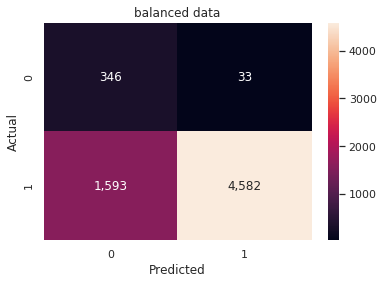

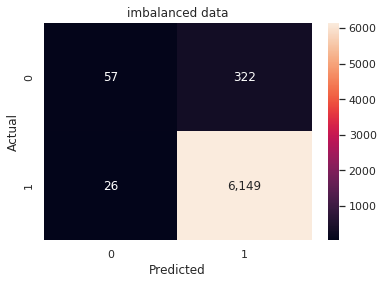

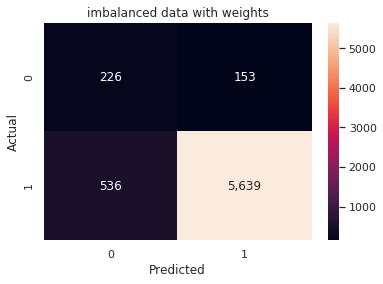

In [15]:
# get the confusion marix for trained models
preds = [d_pred, pred, w_pred]
titles = ['balanced data', 'imbalanced data','imbalanced data with weights']

for x,y in zip(preds, titles):
    plot_confusion_matrix(y_valid, x, title=y)

By default we CatBoost using `PredictionValuesChange` type in in `get_feature_importance()`

For each feature, **PredictionValuesChange** shows the average the prediction change if the feature value change. The bigger the importance value the bigger on average is the change to the prediction if this feature is changed.

You will **get normalized values** as the ouput (all the importances will add up to 100).

In [16]:
# function to plot feature importance
def plot_feature_importance(model, title=None):
    
    """
    get_feature_importance():
     params:
      prettified - if value is set to True returns the feature importances 
                   as a list of the following pairs sorted by feature importance:
                   (feature_id, feature importance)
    """
    
    imp_df = pd.DataFrame(model.get_feature_importance(prettified=True))

    plt.figure(figsize=(15, 5))
    plot = sns.barplot(x='Feature Id', y='Importances', data=imp_df)
    plt.xticks(rotation=45)
    
    if title is None:
        pass
    else:
        plot.set_title(title)
    
    plt.show()

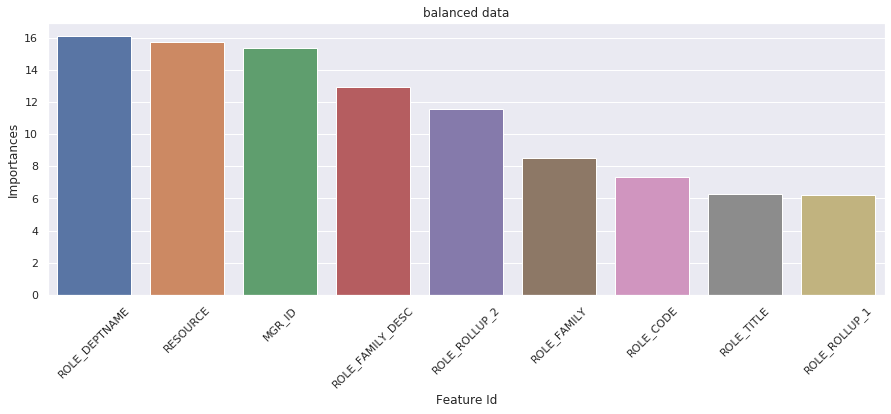

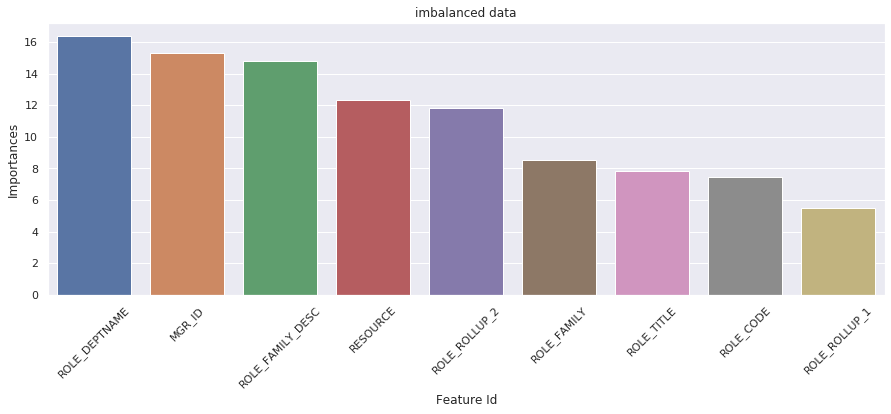

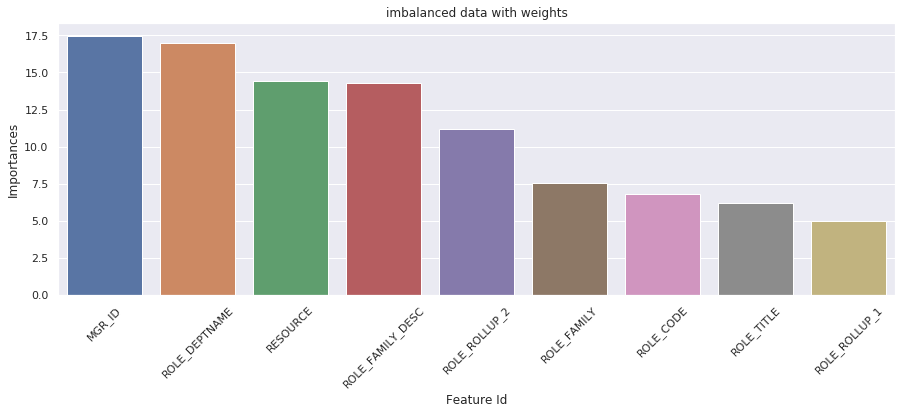

In [17]:
# get the confusion marix for trained models
models = [cb_d1, cb_1, cb_1_w]
titles = ['balanced data', 'imbalanced data','imbalanced data with weights']

for x,y in zip(models, titles):
    plot_feature_importance(x, title=y)

#### with categorical features specification

Firstly we are creating the list of features/columns which we want CatBoost to treat as the categorical ones. And in our dataset all features are categorical.

In [18]:
cat_features = list(range(train_df.drop("ACTION",1).shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [19]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'verbose': 200,
          'random_seed': seed,
          'scale_pos_weight': im_check[0]/im_check[1]
         }
cb_2 = CatBoostClassifier(**params)
cb_2.fit(X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071005
0:	test: 0.8121618	best: 0.8121618 (0)	total: 38.9ms	remaining: 38.9s
200:	test: 0.8796133	best: 0.8800707 (191)	total: 6.48s	remaining: 25.8s
400:	test: 0.8766603	best: 0.8800707 (191)	total: 13s	remaining: 19.4s
600:	test: 0.8759424	best: 0.8800707 (191)	total: 18.8s	remaining: 12.5s
800:	test: 0.8755829	best: 0.8800707 (191)	total: 24s	remaining: 5.97s
999:	test: 0.8742211	best: 0.8800707 (191)	total: 30.1s	remaining: 0us

bestTest = 0.8800707167
bestIteration = 191

Shrink model to first 192 iterations.


In [20]:
# make the predictions
c_pred = cb_2.predict(data=X_valid)
print("Accuracy withcatagorical features:", accuracy_score(y_valid, c_pred))

Accuracy withcatagorical features: 0.8843454379005188


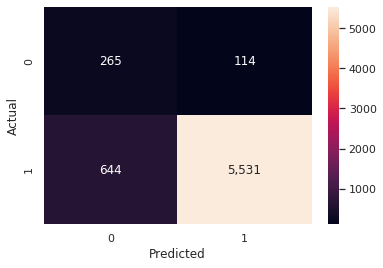

In [21]:
# get the confusion marix for trained models
plot_confusion_matrix(y_valid, c_pred)

#### with categorical features specification and GPU task

By default CatBoost uses CPU to make calculations. In order to use GPU we need to specify **task_type='GPU'**.

In [22]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'task_type': 'GPU',
          'verbose': 200,
          'random_seed': seed,
            'scale_pos_weight': im_check[0]/im_check[1]
         }
cb_3 = CatBoostClassifier(**params)
cb_3.fit(X_train, y_train,
          eval_set=(X_valid, y_valid), 
          use_best_model=True,
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.053945
0:	learn: 0.7146430	test: 0.7631816	best: 0.7631816 (0)	total: 27ms	remaining: 27s
200:	learn: 0.8608958	test: 0.8745315	best: 0.8745315 (200)	total: 7.75s	remaining: 30.8s
400:	learn: 0.8709851	test: 0.8752675	best: 0.8756312 (353)	total: 15.4s	remaining: 23s
600:	learn: 0.8752661	test: 0.8761623	best: 0.8764832 (568)	total: 21.9s	remaining: 14.6s
800:	learn: 0.8797043	test: 0.8762276	best: 0.8765810 (750)	total: 28.3s	remaining: 7.02s
999:	learn: 0.8839813	test: 0.8760781	best: 0.8765810 (750)	total: 34.9s	remaining: 0us
bestTest = 0.876581043
bestIteration = 750
Shrink model to first 751 iterations.


In [23]:
# make the predictions
gpu_pred = cb_3.predict(data=X_valid)
print("Accuracy on GPU:", accuracy_score(y_valid, gpu_pred))

Accuracy on GPU: 0.8605431797375649


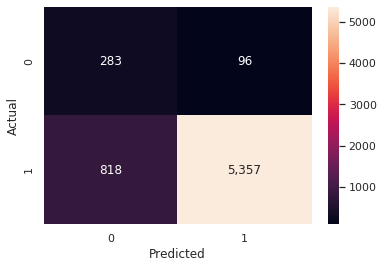

In [24]:
# get the confusion marix for trained models
plot_confusion_matrix(y_valid, gpu_pred)

### Using baseline

You can use pre-trained results (baseline) for training

For `prediction_type` parameter could be specified:
* **Probability** - a number indicating the probability that the object belongs to the class (a sigmoid of the result of applying the model
* **Class** - the predicted class (output with the value “1” if the probability is higher than 0.5, otherwise “0”)
* **RawFormulaVal** -  a number resulting from applying the model

In [25]:
params = {'loss_function':'Logloss',
          'cat_features': cat_features,
          'verbose': 200,
          'random_seed': seed,
          'learning_rate': 0.05,
          'depth': 4
         }


current_params = params.copy()
current_params.update({
    'iterations': 45
})


model = CatBoostClassifier(**current_params).fit(X_train, y_train, verbose=True)

# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')

0:	learn: 0.6550165	total: 10.6ms	remaining: 465ms
1:	learn: 0.6205745	total: 17.6ms	remaining: 377ms
2:	learn: 0.5892895	total: 32.4ms	remaining: 454ms
3:	learn: 0.5608087	total: 39.2ms	remaining: 402ms
4:	learn: 0.5348067	total: 54.9ms	remaining: 439ms
5:	learn: 0.5109836	total: 64.2ms	remaining: 417ms
6:	learn: 0.4891365	total: 69.7ms	remaining: 379ms
7:	learn: 0.4690084	total: 80.1ms	remaining: 371ms
8:	learn: 0.4504401	total: 90.1ms	remaining: 360ms
9:	learn: 0.4333906	total: 95.9ms	remaining: 336ms
10:	learn: 0.4176823	total: 104ms	remaining: 321ms
11:	learn: 0.4030159	total: 112ms	remaining: 308ms
12:	learn: 0.3894401	total: 120ms	remaining: 295ms
13:	learn: 0.3769996	total: 125ms	remaining: 276ms
14:	learn: 0.3654784	total: 129ms	remaining: 258ms
15:	learn: 0.3546712	total: 138ms	remaining: 250ms
16:	learn: 0.3447616	total: 144ms	remaining: 237ms
17:	learn: 0.3354424	total: 151ms	remaining: 227ms
18:	learn: 0.3267378	total: 161ms	remaining: 220ms
19:	learn: 0.3186415	total: 169

In [26]:
model.fit(
    X_train, y_train,
    baseline=baseline,
    verbose=True)

0:	learn: 0.1957303	total: 9.99ms	remaining: 440ms
1:	learn: 0.1936377	total: 18ms	remaining: 387ms
2:	learn: 0.1917200	total: 26.8ms	remaining: 376ms
3:	learn: 0.1899185	total: 34.5ms	remaining: 354ms
4:	learn: 0.1882708	total: 40.2ms	remaining: 321ms
5:	learn: 0.1869631	total: 45.8ms	remaining: 298ms
6:	learn: 0.1854395	total: 50.9ms	remaining: 276ms
7:	learn: 0.1840987	total: 53.9ms	remaining: 250ms
8:	learn: 0.1827405	total: 57.3ms	remaining: 229ms
9:	learn: 0.1815618	total: 66ms	remaining: 231ms
10:	learn: 0.1803705	total: 73.5ms	remaining: 227ms
11:	learn: 0.1793453	total: 80.1ms	remaining: 220ms
12:	learn: 0.1785430	total: 87.3ms	remaining: 215ms
13:	learn: 0.1776854	total: 90.9ms	remaining: 201ms
14:	learn: 0.1768385	total: 94.5ms	remaining: 189ms
15:	learn: 0.1760798	total: 101ms	remaining: 183ms
16:	learn: 0.1755330	total: 104ms	remaining: 171ms
17:	learn: 0.1745547	total: 108ms	remaining: 161ms
18:	learn: 0.1736533	total: 115ms	remaining: 158ms
19:	learn: 0.1728539	total: 12

### Pool object

**CatBoostClassifier.fit()** method can also accept pool object as a train data.

Pool object has some interesting methods:
* `weight` - for specification weights to instances (rows) of our data
* `group_id` - for dividing data on groups
* `group_weight`-for specification different weights for different groups
* `baseline`- we may have  a baseline calculated. Then we will be able to provide initial formula values for all input objects.Thus, training will start from these values for all input objects instead of starting from zero.

In [27]:
# Let's give linear weightage to all the datapoints
weight_t = [ x for x in range(X_train.shape[0])]
weight_v = [ x for x in range(X_valid.shape[0])]

In [28]:
from catboost import Pool

train_data = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features,
                  weight=weight_t
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid,
                  cat_features=cat_features,
                  weight=weight_v
                 )

In [29]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
#           'cat_features': cat_features, # we don't need to specify this parameter as 
#                                           pool object contains info about categorical features
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': seed,
          'scale_pos_weight': im_check[0]/im_check[1]
         }

cb_4 = CatBoostClassifier(**params)
cb_4.fit(train_data, # instead of X_train, y_train
          eval_set=valid_data, # instead of (X_valid, y_valid)
          use_best_model=True, 
          plot=True
         );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.071005
0:	test: 0.7896730	best: 0.7896730 (0)	total: 50.4ms	remaining: 50.3s
200:	test: 0.8762627	best: 0.8762627 (200)	total: 4.23s	remaining: 16.8s
400:	test: 0.8821132	best: 0.8832220 (245)	total: 9.2s	remaining: 13.7s
600:	test: 0.8817538	best: 0.8836591 (517)	total: 14.2s	remaining: 9.43s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8836591072
bestIteration = 517

Shrink model to first 518 iterations.


### Custom loss functions

These functions are not optimized and are displayed for informational purposes only.

You can find additional information in [Objectives and metrics](https://catboost.ai/docs/concepts/loss-functions.htm)

In [30]:
params = {'custom_loss':['AUC', 'Accuracy'],
          'verbose': 200,
          'random_seed': seed,
          'iterations':50,
          'learning_rate':0.5
         }

cb_5 = CatBoostClassifier(**params)
cb_5.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Model comparison

In [31]:
params_m1 = {"learning_rate": 0.7,
         "iterations":100,
         "random_seed":0,
         "train_dir": 'learing_rate_0.7'}

params_m2 = params.copy()
params_m2.update({
    'learning_rate': 0.01,
    "train_dir": 'learing_rate_0.01'})

model1 = CatBoostClassifier(**params_m1)
model2 = CatBoostClassifier(**params_m2)

model1.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
    verbose=False
)

In [32]:
from catboost import MetricVisualizer
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Cross-validation

In [33]:
from catboost import cv

params = {'loss_function': 'Logloss',
          'iterations': 80,
          'custom_loss': 'AUC',
          'random_seed': seed,
          'learning_rate': 0.5}

cv_data = cv(
    params = params,
    pool = Pool(train_df.drop("ACTION",1), 
                label=train_df["ACTION"], 
                cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [34]:
cv_data.head()

iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0           0           0.297471          0.003886            0.297251   
1           1           0.233013          0.007838            0.233119   
2           2           0.192145          0.007205            0.198479   
3           3           0.179276          0.007986            0.187120   
4           4           0.173011          0.007654            0.181654   

   train-Logloss-std  test-AUC-mean  test-AUC-std  
0           0.002553       0.587874      0.011823  
1           0.003082       0.596323      0.030186  
2           0.002261       0.789569      0.021246  
3           0.002663       0.811959      0.016599  
4           0.001789       0.821378      0.007632

In [35]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1583±0.0074 on step 33


### Grid search

In [36]:
grid = {'learning_rate': [0.03, 0.1],
        'n_estimators': [50, 250, 25],
        'depth': [4, 6, 10],
        'one_hot_max_size': [30, 50, 120],
        'random_strength': [0.5, 2, 4],
        'border_count': [30, 120, 5]}

model = catboost.CatBoostClassifier(iterations=400)

grid_search_result = model.grid_search(grid, 
                                       X=train_df.drop("ACTION", 1), 
                                       y=train_df["ACTION"],
                                       cv=3,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2246490701
bestIteration = 49

0:	loss: 0.2246491	best: 0.2246491 (0)	total: 661ms	remaining: 5m 20s

bestTest = 0.2246490701
bestIteration = 49

1:	loss: 0.2246491	best: 0.2246491 (0)	total: 1.22s	remaining: 4m 54s

bestTest = 0.2246490701
bestIteration = 49

2:	loss: 0.2246491	best: 0.2246491 (0)	total: 1.48s	remaining: 3m 58s

bestTest = 0.2022074341
bestIteration = 49

3:	loss: 0.2022074	best: 0.2022074 (3)	total: 1.92s	remaining: 3m 51s

bestTest = 0.2022074341
bestIteration = 49

4:	loss: 0.2022074	best: 0.2022074 (3)	total: 2.2s	remaining: 3m 31s

bestTest = 0.2022074341
bestIteration = 49

5:	loss: 0.2022074	best: 0.2022074 (3)	total: 2.67s	remaining: 3m 33s

bestTest = 0.1976345138
bestIteration = 249

6:	loss: 0.1976345	best: 0.1976345 (6)	total: 3.9s	remaining: 4m 26s

bestTest = 0.1976345138
bestIteration = 249

7:	loss: 0.1976345	best: 0.1976345 (6)	total: 5.08s	remaining: 5m 3s

bestTest = 0.1976345138
bestIteration = 249

8:	loss: 0.1976345	best: 0.1976345 


bestTest = 0.2226792203
bestIteration = 49

72:	loss: 0.2226792	best: 0.1705831 (63)	total: 50.9s	remaining: 4m 48s

bestTest = 0.2226792203
bestIteration = 49

73:	loss: 0.2226792	best: 0.1705831 (63)	total: 51.4s	remaining: 4m 45s

bestTest = 0.2226792203
bestIteration = 49

74:	loss: 0.2226792	best: 0.1705831 (63)	total: 51.8s	remaining: 4m 43s

bestTest = 0.1992374766
bestIteration = 49

75:	loss: 0.1992375	best: 0.1705831 (63)	total: 52.2s	remaining: 4m 41s

bestTest = 0.1992374766
bestIteration = 49

76:	loss: 0.1992375	best: 0.1705831 (63)	total: 52.7s	remaining: 4m 40s

bestTest = 0.1992374766
bestIteration = 49

77:	loss: 0.1992375	best: 0.1705831 (63)	total: 53.2s	remaining: 4m 38s

bestTest = 0.1917321304
bestIteration = 249

78:	loss: 0.1917321	best: 0.1705831 (63)	total: 55.7s	remaining: 4m 47s

bestTest = 0.1917321304
bestIteration = 249

79:	loss: 0.1917321	best: 0.1705831 (63)	total: 58.5s	remaining: 4m 56s

bestTest = 0.1917321304
bestIteration = 249

80:	loss: 0.1917


bestTest = 0.1939024245
bestIteration = 24

142:	loss: 0.1939024	best: 0.1594234 (135)	total: 2m 34s	remaining: 6m 10s

bestTest = 0.1939024245
bestIteration = 24

143:	loss: 0.1939024	best: 0.1594234 (135)	total: 2m 34s	remaining: 6m 7s

bestTest = 0.2143311403
bestIteration = 49

144:	loss: 0.2143311	best: 0.1594234 (135)	total: 2m 35s	remaining: 6m 5s

bestTest = 0.2143311403
bestIteration = 49

145:	loss: 0.2143311	best: 0.1594234 (135)	total: 2m 36s	remaining: 6m 4s

bestTest = 0.2143311403
bestIteration = 49

146:	loss: 0.2143311	best: 0.1594234 (135)	total: 2m 37s	remaining: 6m 2s

bestTest = 0.1829620816
bestIteration = 49

147:	loss: 0.1829621	best: 0.1594234 (135)	total: 2m 38s	remaining: 6m 1s

bestTest = 0.1829620816
bestIteration = 49

148:	loss: 0.1829621	best: 0.1594234 (135)	total: 2m 39s	remaining: 6m

bestTest = 0.1829620816
bestIteration = 49

149:	loss: 0.1829621	best: 0.1594234 (135)	total: 2m 40s	remaining: 5m 59s

bestTest = 0.1747165836
bestIteration = 248

150


bestTest = 0.2854361529
bestIteration = 24

211:	loss: 0.2854362	best: 0.1594234 (135)	total: 3m 41s	remaining: 4m 46s

bestTest = 0.2854361529
bestIteration = 24

212:	loss: 0.2854362	best: 0.1594234 (135)	total: 3m 41s	remaining: 4m 44s

bestTest = 0.2155449838
bestIteration = 24

213:	loss: 0.2155450	best: 0.1594234 (135)	total: 3m 42s	remaining: 4m 42s

bestTest = 0.2155449838
bestIteration = 24

214:	loss: 0.2155450	best: 0.1594234 (135)	total: 3m 42s	remaining: 4m 40s

bestTest = 0.2155449838
bestIteration = 24

215:	loss: 0.2155450	best: 0.1594234 (135)	total: 3m 42s	remaining: 4m 37s

bestTest = 0.2210474642
bestIteration = 49

216:	loss: 0.2210475	best: 0.1594234 (135)	total: 3m 42s	remaining: 4m 36s

bestTest = 0.2210474642
bestIteration = 49

217:	loss: 0.2210475	best: 0.1594234 (135)	total: 3m 42s	remaining: 4m 34s

bestTest = 0.2210474642
bestIteration = 49

218:	loss: 0.2210475	best: 0.1594234 (135)	total: 3m 43s	remaining: 4m 32s

bestTest = 0.1935844496
bestIteration =


bestTest = 0.1599680346
bestIteration = 181

280:	loss: 0.1599680	best: 0.1594234 (135)	total: 4m 51s	remaining: 3m 32s

bestTest = 0.1599680346
bestIteration = 181

281:	loss: 0.1599680	best: 0.1594234 (135)	total: 4m 56s	remaining: 3m 34s

bestTest = 0.2727187387
bestIteration = 24

282:	loss: 0.2727187	best: 0.1594234 (135)	total: 4m 56s	remaining: 3m 32s

bestTest = 0.2727187387
bestIteration = 24

283:	loss: 0.2727187	best: 0.1594234 (135)	total: 4m 57s	remaining: 3m 31s

bestTest = 0.2727187387
bestIteration = 24

284:	loss: 0.2727187	best: 0.1594234 (135)	total: 4m 57s	remaining: 3m 29s

bestTest = 0.1897109056
bestIteration = 24

285:	loss: 0.1897109	best: 0.1594234 (135)	total: 4m 58s	remaining: 3m 28s

bestTest = 0.1897109056
bestIteration = 24

286:	loss: 0.1897109	best: 0.1594234 (135)	total: 4m 58s	remaining: 3m 27s

bestTest = 0.1897109056
bestIteration = 24

287:	loss: 0.1897109	best: 0.1594234 (135)	total: 4m 59s	remaining: 3m 25s

bestTest = 0.2140541912
bestIteration


bestTest = 0.2035466878
bestIteration = 249

349:	loss: 0.2035467	best: 0.1594234 (135)	total: 6m 29s	remaining: 2m 31s

bestTest = 0.2035466878
bestIteration = 249

350:	loss: 0.2035467	best: 0.1594234 (135)	total: 6m 31s	remaining: 2m 30s

bestTest = 0.191552124
bestIteration = 249

351:	loss: 0.1915521	best: 0.1594234 (135)	total: 6m 32s	remaining: 2m 29s

bestTest = 0.191552124
bestIteration = 249

352:	loss: 0.1915521	best: 0.1594234 (135)	total: 6m 33s	remaining: 2m 28s

bestTest = 0.191552124
bestIteration = 249

353:	loss: 0.1915521	best: 0.1594234 (135)	total: 6m 34s	remaining: 2m 27s

bestTest = 0.2855312518
bestIteration = 24

354:	loss: 0.2855313	best: 0.1594234 (135)	total: 6m 34s	remaining: 2m 25s

bestTest = 0.2855312518
bestIteration = 24

355:	loss: 0.2855313	best: 0.1594234 (135)	total: 6m 34s	remaining: 2m 24s

bestTest = 0.2855312518
bestIteration = 24

356:	loss: 0.2855313	best: 0.1594234 (135)	total: 6m 34s	remaining: 2m 22s

bestTest = 0.2128731078
bestIteration


bestTest = 0.2016787491
bestIteration = 49

418:	loss: 0.2016787	best: 0.1594234 (135)	total: 7m 9s	remaining: 1m 8s

bestTest = 0.2016787491
bestIteration = 49

419:	loss: 0.2016787	best: 0.1594234 (135)	total: 7m 10s	remaining: 1m 7s

bestTest = 0.1955066525
bestIteration = 249

420:	loss: 0.1955067	best: 0.1594234 (135)	total: 7m 11s	remaining: 1m 6s

bestTest = 0.1955066525
bestIteration = 249

421:	loss: 0.1955067	best: 0.1594234 (135)	total: 7m 13s	remaining: 1m 5s

bestTest = 0.1955066525
bestIteration = 249

422:	loss: 0.1955067	best: 0.1594234 (135)	total: 7m 14s	remaining: 1m 4s

bestTest = 0.1792073458
bestIteration = 248

423:	loss: 0.1792073	best: 0.1594234 (135)	total: 7m 16s	remaining: 1m 3s

bestTest = 0.1792073458
bestIteration = 248

424:	loss: 0.1792073	best: 0.1594234 (135)	total: 7m 17s	remaining: 1m 2s

bestTest = 0.1792073458
bestIteration = 248

425:	loss: 0.1792073	best: 0.1594234 (135)	total: 7m 19s	remaining: 1m 1s

bestTest = 0.2818564358
bestIteration = 24

### Overfitting detector

`od_wait`- the number of iterations to continue the training after the iteration with the optimal metric value.

In [37]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    od_wait=40
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [38]:
print(model_with_early_stop.tree_count_)

49


### Model predictions

In [39]:
# apply the model to the given dataset to predict the probability 
# that the object belongs to the given classes.
print(model.predict_proba(data=test_df.drop("id", 1)))

[[0.0693 0.9307]
 [0.0063 0.9937]
 [0.0072 0.9928]
 ...
 [0.0664 0.9336]
 [0.0841 0.9159]
 [0.0115 0.9885]]


In [40]:
# apply the model to the given dataset in order to predict the class
print(model.predict(data=test_df.drop("id", 1)))

[1 1 1 ... 1 1 1]


CatBoost model has `staged_predict` method. It allows you to iteratively get predictions for a given range of trees.

In [41]:
predictions_gen = model.staged_predict_proba(
    data=test_df.drop("id", 1),
    ntree_start=0, 
    ntree_end=5, 
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4365 0.5635]
 [0.4232 0.5768]
 [0.4329 0.5671]
 ...
 [0.4329 0.5671]
 [0.426  0.574 ]
 [0.4232 0.5768]]
Iteration 1, predictions:
[[0.3776 0.6224]
 [0.3649 0.6351]
 [0.3725 0.6275]
 ...
 [0.3779 0.6221]
 [0.366  0.634 ]
 [0.3678 0.6322]]
Iteration 2, predictions:
[[0.3347 0.6653]
 [0.3158 0.6842]
 [0.32   0.68  ]
 ...
 [0.3251 0.6749]
 [0.3075 0.6925]
 [0.3185 0.6815]]
Iteration 3, predictions:
[[0.2956 0.7044]
 [0.266  0.734 ]
 [0.2699 0.7301]
 ...
 [0.2948 0.7052]
 [0.2632 0.7368]
 [0.2684 0.7316]]
Iteration 4, predictions:
[[0.2644 0.7356]
 [0.2125 0.7875]
 [0.2303 0.7697]
 ...
 [0.2653 0.7347]
 [0.2358 0.7642]
 [0.2145 0.7855]]


### Feature statistics

What information could be gained:
* **Mean target** - average target(label) value in the bucket
* **Mean prediction on each segment of feature values** - average prediction in the bucket.
* **Objects per bin** - number of objects in the bucket
* **Mean prediction with substituted feature** - average predictions on varying values of the feature

You can get mo information by [link](https://catboost.ai/docs/concepts/python-reference_catboostregressor_calc_feature_statistics.html)

In [42]:
from catboost import CatBoostRegressor
import numpy as np

train_data = np.random.rand(200, 25)
label_values = np.random.rand(200)

model = CatBoostRegressor()
model.fit(train_data, label_values, silent=True)

res = model.calc_feature_statistics(train_data,
                                    label_values,
                                    feature=2,
                                    plot=True)

# XGBoost vs LightGBM vs CatBoost

We will look through the several differences between algorithms because your **homework** will be to create the tutorial and compare to XGBoost and LightGBM algorithms.

| Feature | XGBoost | LightGBM | CatBoost |
| :----: | :----: | :----: | :----: |
| Splits | Not using any weighted sampling techniques | Minimal Variance Sampling  | Gradient-based one-side sampling |
| Leaf growth | Level-wise (best-first) tree growth | Leaf-wise (best-first) tree growth  | Grows a balanced tree |
| Missing values handling | Missing values will be allocated to the side that reduces the loss in each split | <--| Has two modes for processing missing values, “Min” and “Max” |
| Feature importance methods | “Gain”, “Frequency”,“Coverage”  | “Gain”, “Split”  | Has two methods: “PredictionValuesChange” and “LossFunctionChange”|
| Categorical features handling | Doesn’t have an inbuilt method for categorical features | Splits categorical features by partitioning their categories into 2 subsets. But thess features must be encoded as non-negative integers | Uses a combination of one-hot encoding and an advanced mean encoding |

# Useful resources
- Main course [site](https://mlcourse.ai), [course repo](https://github.com/Yorko/mlcourse.ai), and YouTube [channel](https://www.youtube.com/watch?v=QKTuw4PNOsU&list=PLVlY_7IJCMJeRfZ68eVfEcu-UcN9BbwiX)
- Course materials as a [Kaggle Dataset](https://www.kaggle.com/kashnitsky/mlcourse)
- mlcourse.ai lectures on gradient boosting: [theory](https://youtu.be/g0ZOtzZqdqk) and [practice](https://youtu.be/V5158Oug4W8)
- [Original article](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) about GBM from Jerome Friedman
- “Gradient boosting machines, a tutorial”, [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/) by Alexey Natekin, and Alois Knoll
- [Chapter in Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf) from Hastie, Tibshirani, Friedman (page 337)
- [Wiki](https://en.wikipedia.org/wiki/Gradient_boosting) article about Gradient Boosting
- [CatBoost: unbiased boosting with categorical features](https://arxiv.org/pdf/1706.09516.pdf) - scientific article, Jan 2019.
- [CatBoost: gradient boosting with categorical features
support](https://arxiv.org/pdf/1810.11363.pdf) - scientific article, Oct 2018.
- You can find all CatBoost parameters, methods and tutorials in [CatBoost Documentation](catboost.a)
- [Introduction to boosted trees (Xgboost docs)](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video-lecture by Hastie](https://www.youtube.com/watch?v=wPqtzj5VZus) about GBM at h2o.ai conference
- [CatBoost vs. Light GBM vs. XGBoost](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db) on "Towards Data Science"
- [Benchmarking and Optimization of
Gradient Boosting Decision Tree Algorithms](https://arxiv.org/abs/1809.04559), [XGBoost: Scalable GPU Accelerated Learning](https://arxiv.org/abs/1806.11248) - benchmarking CatBoost, Light GBM, and XGBoost (no 100% winner)